# **📚 Delta table statistics, maintenance and properties configuration**

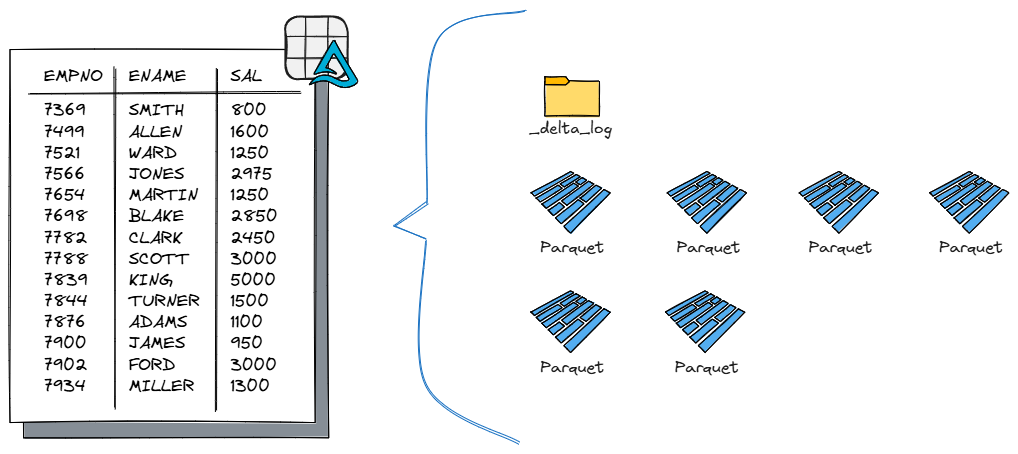

This notebook serves as an example of the possible implementation and subsequent automation of audit and maintenance operations on the tables in our lakehouse.

It extends functionality and allows you to streamline [maintenance operations available from the lakehouse explorer](https://learn.microsoft.com/en-us/fabric/data-engineering/lakehouse-table-maintenance) and schedule them as needed, as well as check the evolution of the tables residing in it and the configuration of their properties.

In this way, we achieve a more efficient, robust, and complete ecosystem.

<mark>**IMPORTANT:**</mark> Remember to attach your own lakehouse to the notebook in order to test and try the samples provided.

### 🔗 Imports and references

In [ ]:
from datetime import datetime, timedelta
from delta.tables import DeltaTable
from pyspark.sql.functions import max, col
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, TimestampType, BooleanType

### 🛠️ Functions

There are a total of five functions defined:
* **get_delta_table_property**, retrieves the specified property from the Delta table properties collection. <br><br>
* **get_delta_table_details**, inspired by [Sandeep Pawar](https://fabric.guru/analyze-delta-tables-in-fabric), we collect some details from the statistics available for each Delta table. This allows us to look up the latest maintenance timestamps and/or check how the tables are growing, enabling us to monitor their status and avoid falling into the [limitations of Direct Lake mode](https://learn.microsoft.com/en-us/fabric/fundamentals/direct-lake-overview#fabric-capacity-requirements). We can later iterate over this results in order to perform maintenance. <br><br>
* **run_delta_table_compaction**, runs the OPTIMIZE command for the table if is not configured for auto compaction. <br><br>
* **run_delta_table_vacuum**, performs the VACUUM command over the table if it fits within the time window defined by the retention period. <br><br>
* **set_delta_table_property**, we cannot only retrieve properties for each Delta table, we can also establish their values!


In [ ]:
def get_delta_table_property(table_name: str, table_property: str) -> str:
    """
    Retrieves the specified property from the Delta table provided. 
    Requires a lakehouse attached to the notebook in order to load the table and get its properties.

    Args:
        table_name (str): Delta table where we will check the property.
        table_property (str): Property we wish to look for.

    Returns:
        str: Value retrieved for the property, an empty string is returned if the property is not found.
    """
    # Load table and check for the specified property status
    delta_table = DeltaTable.forName(spark, table_name)
    delta_table_properties = delta_table.detail()\
        .select("properties").first()[0]
    property_status: str = delta_table_properties.get(table_property, "")

    return property_status


def get_delta_table_details(workspace_name: str, lakehouse_name: str, table_name: str, count_rows_flag: bool | None = None) -> tuple:
    """
    Gathers details for the provided Delta table.
    Requires a lakehouse attached to the notebook in order to retrieve results for the table.
    Counting rows is optional and can be skipped, which will acount to -1 value rows for the table.

    Args:
        workspace_name (str): Name of the workspace in which the lakehouse resides.
        lakehouse_name (str): Name of the attached main lakehouse.
        table_name (str): Delta table from which we will obtain results.
        count_rows_flag (bool, optional): Flag to control the row counting operation, can be omitted. Defaults to None.

    Returns:
        tuple: Gathered results for the specified table.
    """
    # Get details from catalog through the DESCRIBE DETAIL Spark SQL command
    table_detail_df = spark.sql(f"DESCRIBE DETAIL `{table_name}`").collect()[0]

    # Calculate table statistics
    num_files: int = table_detail_df.numFiles
    bytes_size: int = table_detail_df.sizeInBytes
    size_in_mb: int = int(round(bytes_size / (1048576),0))
    num_rows: int = spark.table(table_name).count() if count_rows_flag else -1

    # Check table history for optimize and vacuum operations thanks to DESCRIBE HISTORY Spark SQL command
    table_history_df = spark.sql(f"DESCRIBE HISTORY `{table_name}`")
    last_optimize: datetime = table_history_df.where(table_history_df.operation == "OPTIMIZE") \
        .select(max(table_history_df.timestamp)).first()[0]
    last_vacuum: datetime = table_history_df.where(table_history_df.operation == "VACUUM END") \
        .select(max(table_history_df.timestamp)).first()[0]

    # Check if table is configured for automatic compaction
    auto_compaction_property_name: str = "delta.autoOptimize.autoCompact"
    auto_compaction_status: str = get_delta_table_property(table_name=table_name, table_property=auto_compaction_property_name)
    auto_compaction_flag: bool = True if auto_compaction_status=="true" else False

    return workspace_name, lakehouse_name, table_name, num_files, num_rows, size_in_mb, auto_compaction_flag, last_optimize, last_vacuum


def run_delta_table_compaction(table_name: str) -> None:
    """
    Executes the OPTIMIZE command for the specified Delta table.
    Requires a lakehouse attached to the notebook in order to load and compact the table.
    Checks if the table is configured for auto-compaction, in which case skips the operation.
    Employs the previous defined function get_delta_table_property to search for the auto-compaction property.

    Args:
        table_name (str): Delta table on which we will perform the compaction.
    """
    # Perform OPTIMIZE operation taking autocompact into account
    # Over auto compaction tables OPTIMIZE command should not be run
    print(f"⏳ {datetime.now()} - ⏱️ Starting to optimize table {table_name}...")

    # We check the property before applying any operation
    auto_compact_check: str = get_delta_table_property(table_name=table_name, table_property="delta.autoOptimize.autoCompact")
    auto_compact_flag: bool = True if auto_compact_check=="true" else False

    if auto_compact_flag:
         print(f"⌛ {datetime.now()} - ⚠️ The table {table_name} is configured for automatic compaction, it is not necessary to perform the operation.")
    else:
        delta_table = DeltaTable.forName(spark, table_name)
        delta_table.optimize().executeCompaction()
        print(f"⌛ {datetime.now()} - ✅ Ended optimizing table {table_name} successfully.")


def run_delta_table_vacuum(table_name: str, vacuum_retention_period: int = 168, last_vacuum_date: datetime | None = None) -> None:
    """
    Performs the VACUUM operation over the specified table.
    Requires a lakehouse attached to the notebook in order to load the table and delete its inactive files.
    VACUUM does not run if the last cleanup operation was performed within the defined retention period.

    Args:
        table_name (str): Delta table on which we will perform the cleanup.
        vacuum_retention_period (int, optional): Number of days (in hours) for which we want to preserve results. Defaults to 168 (7 days).
        last_vacuum_date (datetime, optional): Last cleanup operation timestamp, can be skipped. Defaults to None.
    """
    # Perform VACUUM operation taking into account existing timestamps and specified retention period
    print(f"⏳ {datetime.now()} - ⏱️ Starting to vacuum table {table_name}...")
    current_date_adjusted: datetime = datetime.now() - timedelta(hours=vacuum_retention_period)
    if not last_vacuum_date or last_vacuum_date < current_date_adjusted:
        delta_table = DeltaTable.forName(spark, table_name)
        delta_table.vacuum(vacuum_retention_period)
        print(f"⌛ {datetime.now()} - ✅ Ended vacuuming table {table_name} successfully.")
    else:
        print(f"⌛ {datetime.now()} - ⚠️ The last vacuum performed for table {table_name} is within the defined interval, it is not necessary to perform the operation.")


def set_delta_table_property(table_name: str, property_name: str, property_value: str) -> None:
    """
    Sets the property provided to the specified value received in the given Delta table.
    Requires a lakehouse attached to the notebook in order to operate over the table.
    Employs the previous defined function get_delta_table_property to search for the specified property.

    Args:
        table_name (str): Delta table where we will configure the property (if valid).
        property_name (str): Name of the property that needs to be established.
        property_value (str): _description_
    """
    # Check the current value for the property and proceed as needed
    actual_property_status: str = get_delta_table_property(table_name=table_name, table_property=property_name)

    if actual_property_status and actual_property_status != property_value:
        try:
            set_property_command: str = f"ALTER TABLE {table_name} SET TBLPROPERTIES ( '{property_name}' = '{property_value}')"
            spark.sql(set_property_command)
            print(f"⌛ {datetime.now()} - ✅ Property {property_name} correctly established for table {table_name}.")
        except Exception as err:
            print(f"⌛ {datetime.now()} - ❌ Property {property_name} could not be established for table {table_name}, \
                please check the specified property and/or that the table is not a shortcut.")
    else:
        print(f"⌛ {datetime.now()} - ⚠️ Table {table_name} is already configured for {property_name} or property does not exist.")

### 🔍 Let's crunch some numbers!

An important aspect to consider within our data lakehouse is the growth and evolution of our tables over time. Operating on them without worrying about their statistics and/or performing maintenance operations on our ecosystem does not pay off well; we will likely experience both inefficient operation times and an increase in unnecessary storage costs.

So how do we solve this? The most important thing is to collect the necessary data (information is power!) in order to proactively carry out the necessary corrective measures (and if it can be done automatically, all the better).

In the example, we go through all the tables in our attached lakehouse (<mark>**remember to attach yours!**</mark>), except temporary and external tables, to collect their statistics. Specifically, we look for their disk size, number of rows and files, as well as their last compaction and cleanup runs, and check whether they are configured to do so automatically.

In [ ]:
# Get attached lakehouse and workspace names, can be overriden with specific values
lakehouse_name: str = spark.conf.get("trident.lakehouse.name")
workspace_name: str = mssparkutils.env.getWorkspaceName()

# Get all tables from the attached lakehouse
# We just want to operate over managed and non temporary tables
# Optionally, we can exclude some lakehouse tables from the process
lh_catalog_tables: list = spark.catalog.listTables()
tables_to_skip: set = {"sample_excluded_table_01","sample_excluded_table_02"}
filtered_tables: list = (table.name for table in lh_catalog_tables if table.tableType == 'MANAGED' \
    and not table.isTemporary and table.name not in tables_to_skip)

# Gather details for each table on the list
# Counting rows operation can be expensive, parameter can be omitted
gathered_details: list = (get_delta_table_details(workspace_name=workspace_name, 
    lakehouse_name=lakehouse_name, 
    table_name=table, 
    count_rows_flag=True) for table in filtered_tables)

stats_table_schema = StructType([
 StructField("workspace", StringType(), True),
 StructField("lakehouse", StringType(), True),
 StructField("table", StringType(), True),
 StructField("num_files", IntegerType(), True),
 StructField("num_rows", IntegerType(), True),
 StructField("delta_size_mb", IntegerType(), True),
 StructField("auto_compaction", BooleanType(), True),
 StructField("last_optimize", TimestampType(), True),
 StructField("last_vacuum", TimestampType(), True)
])
stats_table_df = spark.createDataFrame(gathered_details, stats_table_schema)

# We can take a look over the results or we could write them to an specific table in the environment
display(stats_table_df)

### 🧹Delta table maintenance

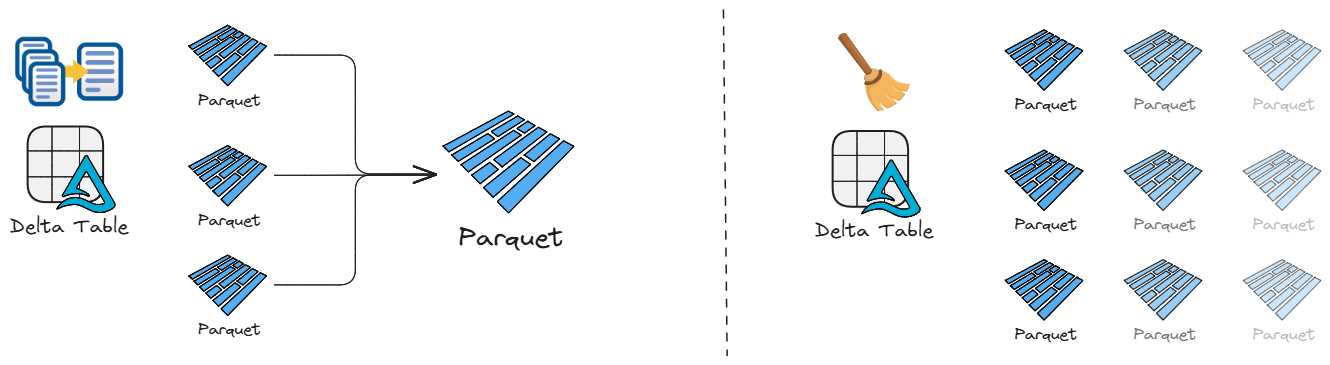

Now that we have the numbers, we can apply the necessary maintenance operations to compact the files that make up our Delta tables and delete those that no longer need to be kept.

Although we can perform this operation from the lakehouse interface itself, this way we can do it more quickly, unattended, and even schedule it to be performed periodically as needed!

In [ ]:
# Based on the results obtained above, we proceed with the maintenance of the tables
# You should execute the previous code fragment or adapt this one as you need
# I haven't been able to find a way to identify tables originating from a shortcut in the properties
# These tables should be excluded from maintenance, operations should be performed on/by their source artifact if possible
excluded_tables: set = {"sample_metadata_table"}
maintenance_candidates: list = (row.asDict() for row in stats_table_df.filter(~col("table").isin(excluded_tables)).collect())

# Configuring session properties to facilitate operations and exceed the established retention period limit if necessary
# The default retention period is 168 hours (7 days)
# It is not recommended to set a retention period too close to 0
spark.conf.set("spark.databricks.delta.vacuum.parallelDelete.enabled", "true")
spark.conf.set("spark.databricks.delta.retentionDurationCheck.enabled", "false")
desired_retention_period: int = 168

# Perform operations as needed for each table
# We loop through all the tables in the maintenance_candidates list but we could expand the possibilities with a metadata database
for table in maintenance_candidates:
    # Retrieve all the needed properties
    table_name: str = table.get("table")
    last_vacuum: datetime = table.get("last_vacuum")

    # Run maintenance jobs as needed
    run_delta_table_compaction(table_name=table_name)
    run_delta_table_vacuum(table_name=table_name, vacuum_retention_period=desired_retention_period, last_vacuum_date=last_vacuum)

### 🤖 Properties configuration & automation

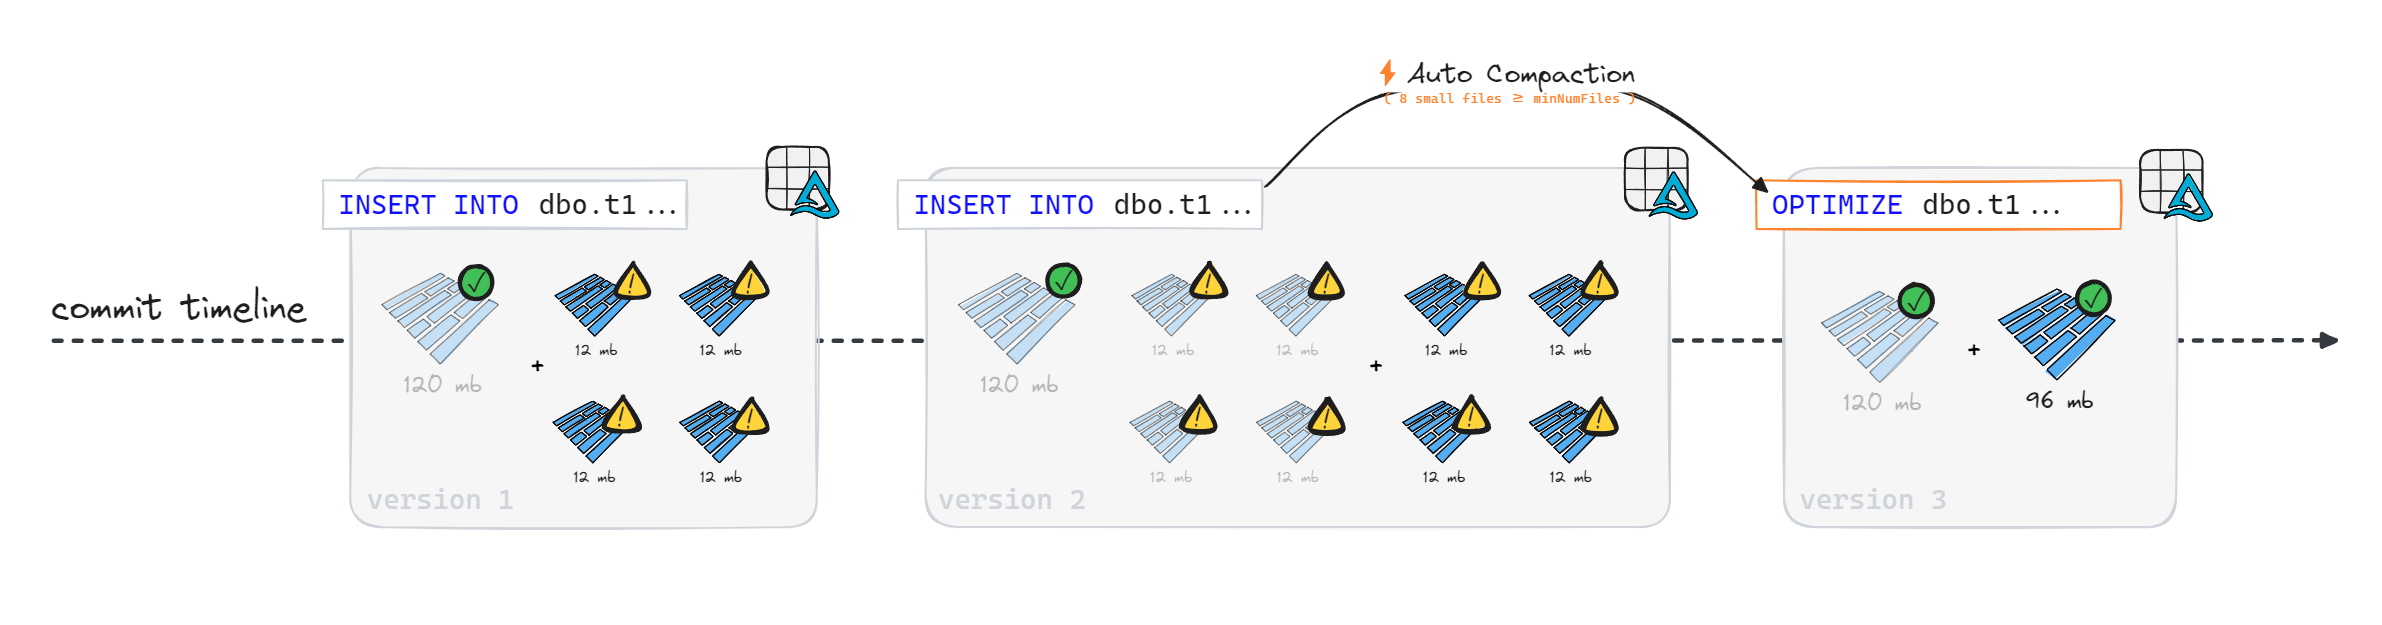

_Image by [Miles Cole](https://milescole.dev/data-engineering/2025/02/26/The-Art-and-Science-of-Table-Compaction.html)_

<br>

What could be better than having a clean house? Having someone else do it for us!

For maintenance, we have a property within the Delta tables that enables the tables to self-compact without us having to do anything. This way, depending on the evolution of the table itself, compaction is applied automatically and prevents its performance from deteriorating. To do this, we need to activate the `delta.autoOptimize.autoCompact` property within our tables. We have focused on this property to follow the maintenance thread shown above, but we could actually automate a check and configuration of the different Delta tables in our lakehouse thanks to the provided function and the example.

Although we can automate compaction within our tables, it is important to consider the most appropriate scenarios and considerations for performing this action. Be sure to check [Miles Cole's article](https://milescole.dev/data-engineering/2025/02/26/The-Art-and-Science-of-Table-Compaction.html) for more info about it.

As for cleaning, I'm afraid we still have to vacuum for now, but we can schedule it ;)


In [ ]:
# As before, it is advisable to exclude tables that come from a shortcut for this operation
# Or the ones in which you do not wanna configure the property
catalog_tables: list = (table for table in spark.catalog.listTables() if table.tableType == 'MANAGED' and not table.isTemporary)

for table in catalog_tables:
    # We choose the auto compaction property as an example
    desired_property_name: str = "delta.autoOptimize.autoCompact"
    desired_property_value: str = "true"

    set_delta_table_property(table_name=table.name, property_name=desired_property_name, property_value=desired_property_value)